# IROS 2020 workshop: REVIEW ON SCREW THEORY & GEOMETRIC ROBOT DYNAMICS

This notebook corresponds to my virtual tutorial at the IROS 2020 workshop on Screw Theory and Geometric Robot Dynamics.

First, import some packages, and set things up just so.

In [3]:
import numpy as np

import roboticstoolbox as rtb
from spatialmath.base import *
from spatialmath import SE3, Twist3
import matplotlib.pyplot as plt

np.set_printoptions(linewidth=100, formatter={'float': lambda x: f"{x:8.4g}" if abs(x) > 1e-10 else f"{0:8.4g}"})

%matplotlib notebook

## Creating and using a simple Denavit-Hartenberg model
First we define a robot, we will choose the classical Puma robot which includes both a kinematic and dynamic model

In [4]:
puma = rtb.models.DH.Puma560()

which has created an object in the local _workspace_ which subclasses the `DHRobot` class which subclasses the top-level `Robot` class.  If we print this we get some detailed information about it's kinematics as well as the base and tool transforms, and some predefined joint configurations

In [5]:
print(puma)

┏━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┓
┃θⱼ ┃   dⱼ    ┃   aⱼ   ┃   ⍺ⱼ   ┃
┣━━━╋━━━━━━━━━╋━━━━━━━━╋━━━━━━━━┫
┃q1 ┃   0.672 ┃      0 ┃  90.0° ┃
┃q2 ┃       0 ┃ 0.4318 ┃   0.0° ┃
┃q3 ┃ 0.15005 ┃ 0.0203 ┃ -90.0° ┃
┃q4 ┃  0.4318 ┃      0 ┃  90.0° ┃
┃q5 ┃       0 ┃      0 ┃ -90.0° ┃
┃q6 ┃       0 ┃      0 ┃   0.0° ┃
┗━━━┻━━━━━━━━━┻━━━━━━━━┻━━━━━━━━┛

┌───┬────────────────────────────┐
│qz │ 0°, 0°, 0°, 0°, 0°, 0°     │
│qr │ 0°, 90°, -90°, 0°, 0°, 0°  │
│qs │ 0°, 0°, -90°, 0°, 0°, 0°   │
│qn │ 0°, 45°, 180°, 0°, 45°, 0° │
└───┴────────────────────────────┘



and we can plot the robot in its zero-joint-angle configuration

<IPython.core.display.Javascript object>


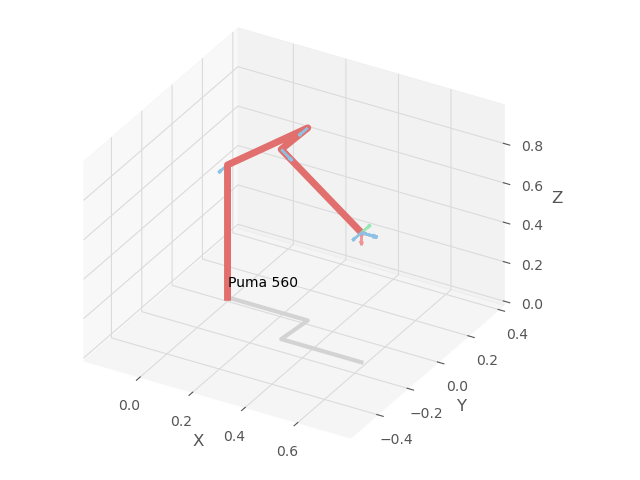

In [6]:
puma.plot(puma.qn);

For an arbitrary set of joint angles

In [ ]:
q = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]

we can compute the end-effector pose using forward kinematics, taking into account the base and tool transforms

In [ ]:
T = puma.fkine(q)
T

the result is an SE(3) matrix, an instance of an `SE3` object.  It is shown with the rotational part in red, the translational part in blue, and the constant part in grey.

To find the inverse kinematics corresponding to this end-effector pose we solve the inverse kinematics numerically

In [ ]:
q, *_ = puma.ikine(T)
q

_Note: that `ikine` returns additional status information which we are ignoring here_

The manipulability at this particular configuration is

In [ ]:
puma.maniplty(q)

and the Jacobian, in the world frame (indicated by the `0` suffix) is

In [ ]:
puma.plot(puma.qn, vellipse=True);

In [ ]:
puma.jacob0(q)

the Jacobian in the end-effector frame is given by `jacobe`.

## More models
A list of all models currently defined in the Toolbox is given by

In [ ]:
rtb.models.list()

which highlights the three categories of robot models supported by the toolbox:

1. DH - expressed using standard or modified Denavit-Hartenberg parameters, and may include dynamic parameters, meshs and collision objects
2. ETS - expressed as a string of elementary transforms, does not support dynamic parameters
3. URDF - based on a URDF file with some additional meta-data, and may include dynamic parameters, meshs and collision objects

### Elementary transform sequence (ETS) models
We can express the Puma 560 simply and concisely as a string of elementary transforms.  First we import the class and then define the key dimensions/offsets of the robot

In [ ]:
import roboticstoolbox.robot.ET as ET

l1 = 0.672
l2 = 0.2337
l3 = 0.4318
l5 = 0.4318
l4 = -0.0837
l6 = 0.0203

Consider the robot in a configuration where it is stretched out vertically, this will be our zero-joint-angle configuration.  Then starting at the base we define a series of rigid-body motions all the way to the tip.  The motion can be:

- constant, indicated by an argument to the method, or
- a variable, due to a joint, and this is indicated by no argument to the method

In [ ]:
e = ET.tz(l1) * ET.rz() * ET.ty(l2) * ET.ry() * ET.tz(l3) * ET.tx(l6) * ET.ty(l4) * ET.ry() \
    * ET.tz(l5) * ET.rz() * ET.ry() * ET.rz()

The overloaded `*` indicates composition of the rigid-body motions.  The total number of elementary transforms is

In [ ]:
len(e)

and the elements which are joints are

In [ ]:
e.joints()

and we can pretty print the transform sequence by

In [ ]:
print(e)

We can also evaluate the transform sequence, by subsituting in values for the joint angles.  They are taken from consecutive elemements of the joint-angle vector provide to the `eval` method

In [ ]:
e.eval([0, 0, 0, 0, 0, 0])

In [ ]:
puma.fkine(puma.qr)

and this is the forward kinematics of a robot described by this elementary transform sequence.

## Robot dynamics
We can define a different joint configuration `q`, as well as the joint velocity `qd` and acceleration `qdd`

In [ ]:
q = puma.qn
qd = np.zeros((6,))
qdd = np.zeros((6,))

and then compute the inverse dynamics using the recursive Newton-Euler algorithm

In [ ]:
puma.rne(q, qd, qdd)

which is written in C for performance. It's actually the same 20 year C-code used in the MATLAB version of the Toolbox!

We can use this to compute the manipulator inertia matrix

In [ ]:
puma.inertia(q)

the velocity terms

In [ ]:
puma.coriolis(q, [0.1, 0.2, 0.3, 0.1, 0.2, 0.3])

where the second argument is the joint velocuty.

Finally, the gravity torque is

In [ ]:
puma.gravload(q)

If we set the joint torques to zero, ie. turn the motors off

In [ ]:
tau = np.zeros((6,))

then the resulting joint angle acceleration will be

In [ ]:
puma.accel(q, qd, tau)

which we can integrate over time to obtain a joint angle trajectory

In [ ]:
tg = puma.nofriction().fdyn(5, puma.qn, dt=0.05)
rtb.tools.trajectory.qplot(tg.q, tg.t, block=True)

Note: _Coulomb friction is a harsh non-linearity and it causes the numerical integrator to take very small times steps, so the result will take many minutes to compute. To speed things up, at the expense of some modeling fidelity, we set the Coulomb friction to zero, but retain the viscous friction. The `nofriction()` method returns a clone of the robot with its friction parameters modified._

# Twists and screws

## Starting simply
The Toolbox provides functions to convert to and from vectors to skew-symmetric matrices (elements of so(2), so(3)) and augmented skew-symmetric matrices (elements of se(2), se(3))

In [ ]:
S = skew([1, 2, 3])
S

In [ ]:
vex(S)

In [ ]:
S = skewa([1, 2, 3, 4, 5, 6])
S

In [ ]:
vexa(S)

## 3D twists
We can create a revolute twist by specifying the direction of its line of action and a point

In [ ]:
Twist3.R([1, 0, 0], [0, 0, 0])

 which is a 6-vector encapsulated in an instance of a `Twist3` object.  A prismatic twist has just the direction of its line of action

In [ ]:
Twist3.P([0, 1, 0])

We can convert an SE(3) matrix, encapsulated in an instance of an `SE3` object to a 3D twist

In [ ]:
T = SE3.Rand()
tw = Twist3(T)
tw

Twists have a number of properties and methods. The moment is a 3-vector

In [ ]:
tw.v

as is the direction part

In [ ]:
tw.w

A twist also has a pitch

In [ ]:
tw.pitch()

and a pole

In [ ]:
tw.pole()

The line of action of the twist is a line in 3D space which can be represented by a Toolbox Plucker object

In [ ]:
tw.line()

which we could plot, by first defining a plot volume

In [ ]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d", "proj_type": "ortho"})
ax.set_xlim3d(-10, 10)
ax.set_ylim3d(-10, 10)
ax.set_zlim3d(-10, 10)

tw.line().plot(color='red', linewidth=2)

plt.show()

## Exponentiation of twists
Importantly, we can exponeniate the twist, ie. compute $T = e^{[S]\theta}$, where $\theta$ is the argument

In [ ]:
tw.exp(0)

which is of course the identity matrix, and

In [ ]:
tw.exp(1)

All Toolbox objects can contain multiple values, so in this example, we exponentiate the twist with a sequence of values, resulting in a single `SE3` object that contains a sequence of SE(3) values.

In [ ]:
T = tw.exp([0, 1])
T

and we access them in a familiar Pythonic way

In [ ]:
len(T)

In [ ]:
T[1]

## Product of exponentials

For the robot model we created earlier, we can extract its product of exponentials representation, a set of six twists and a transformation

In [ ]:
S, T0 = puma.twists()

where the transformation for zero-joint-angles is

In [ ]:
T0

and the twists are

In [ ]:
S

For a nominal joint-angle configuration

In [ ]:
puma.qn

we can exponentiate the twists

In [ ]:
S.exp(puma.qn)

where the result is again an `SE3` object with multiple values, six in this case.

The full expression for the forward kinematics is

In [ ]:
S.exp(puma.qn).prod() * T0

which of course is identical to the classical approach 

In [ ]:
puma.fkine(puma.qn)

Extending an earlier example, the lines of actions of the twists are

In [ ]:
lines = S.line()
lines

Which we can overlay on a plot of the robot in its zero-angle configuration

In [ ]:
fig = puma.plot(puma.qz)

In [ ]:
fig = puma.plot(puma.qz, block=False)
lines.plot("k--", linewidth=1.5, bounds=np.r_[-1, 1, -1, 1, -1, 1.5])
plt.show()

In [ ]:
from spatialmath import SO3, SE2
SO3.Ry(90, unit='deg')

In [ ]:
SE2() * SO3()

In [ ]:
tw.exp(0)

In [ ]:
tw.exp(1)

In [ ]:
tw.exp([0, 1])

In [ ]:
Twist3.P([1, 0, 0])

In [ ]:
Twist3.Rx(0)